<a href="https://colab.research.google.com/github/ketsiamm/byuids-portfolio/blob/main/notebooks/starter_bikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')




<ipython-input-13-6acedc84258b>:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="User Type")


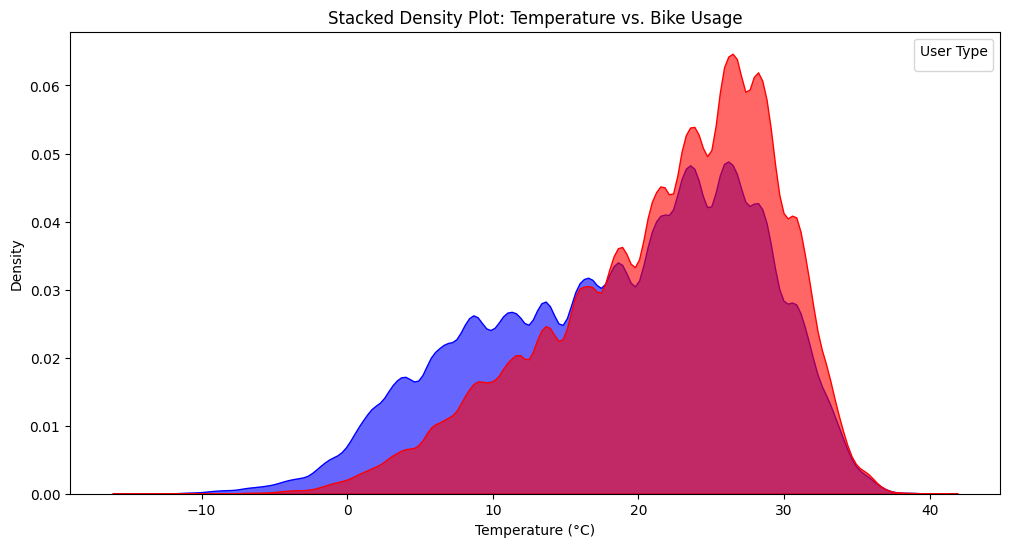

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# bike usage in times

bikes_melted = bikes.melt(id_vars=["temp_c"], value_vars=["casual", "registered"],
                          var_name="User Type", value_name="Users")

plt.figure(figsize=(12, 6))


sns.kdeplot(data=bikes_melted, x="temp_c", hue="User Type", weights="Users",
            fill=True, common_norm=False, bw_adjust=0.5, alpha=0.6, palette=["red", "blue"])


plt.title("Stacked Density Plot: Temperature vs. Bike Usage")
plt.xlabel("Temperature (°C)")
plt.ylabel("Density")
plt.legend(title="User Type")
plt.show()



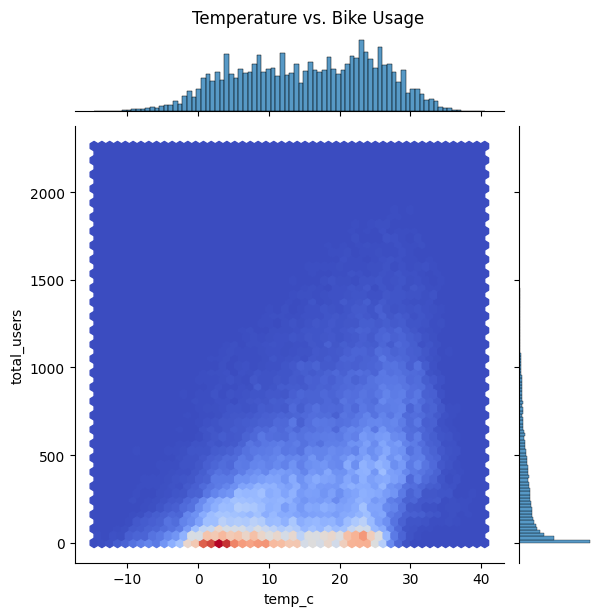

In [10]:
sns.jointplot(x="temp_c", y="total_users", data=bikes, kind="hex", cmap="coolwarm")
plt.suptitle("Temperature vs. Bike Usage", y=1.02)
plt.show()


In [15]:
import pandas as pd
import plotly.express as px

# i kinda use chat gpt for this plot  hahahahaha
bikes["total_users"] = bikes["casual"] + bikes["registered"]


bikes["hour_label"] = bikes["hr"].apply(lambda x: f"{x}:00")


bikes_melted = bikes.melt(id_vars=["hour_label"], value_vars=["casual", "registered"],
                          var_name="User Type", value_name="Users")


fig = px.area(
    bikes_melted,
    x="hour_label",
    y="Users",
    color="User Type",
    title="📊 Interactive Stacked Area Chart: Hourly Bike Usage",
    labels={"hour_label": "Hour of the Day", "Users": "Number of Users"},
    color_discrete_map={"casual": "red", "registered": "blue"},
)


fig.update_layout(
    xaxis=dict(tickmode="linear", dtick=2),  # Show every 2 hours
    yaxis_title="Total Users",
    hovermode="x unified",  # Show hover info for both categories at once
    legend_title="User Type"
)


fig.show()


In [ ]:
bikes.hr.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

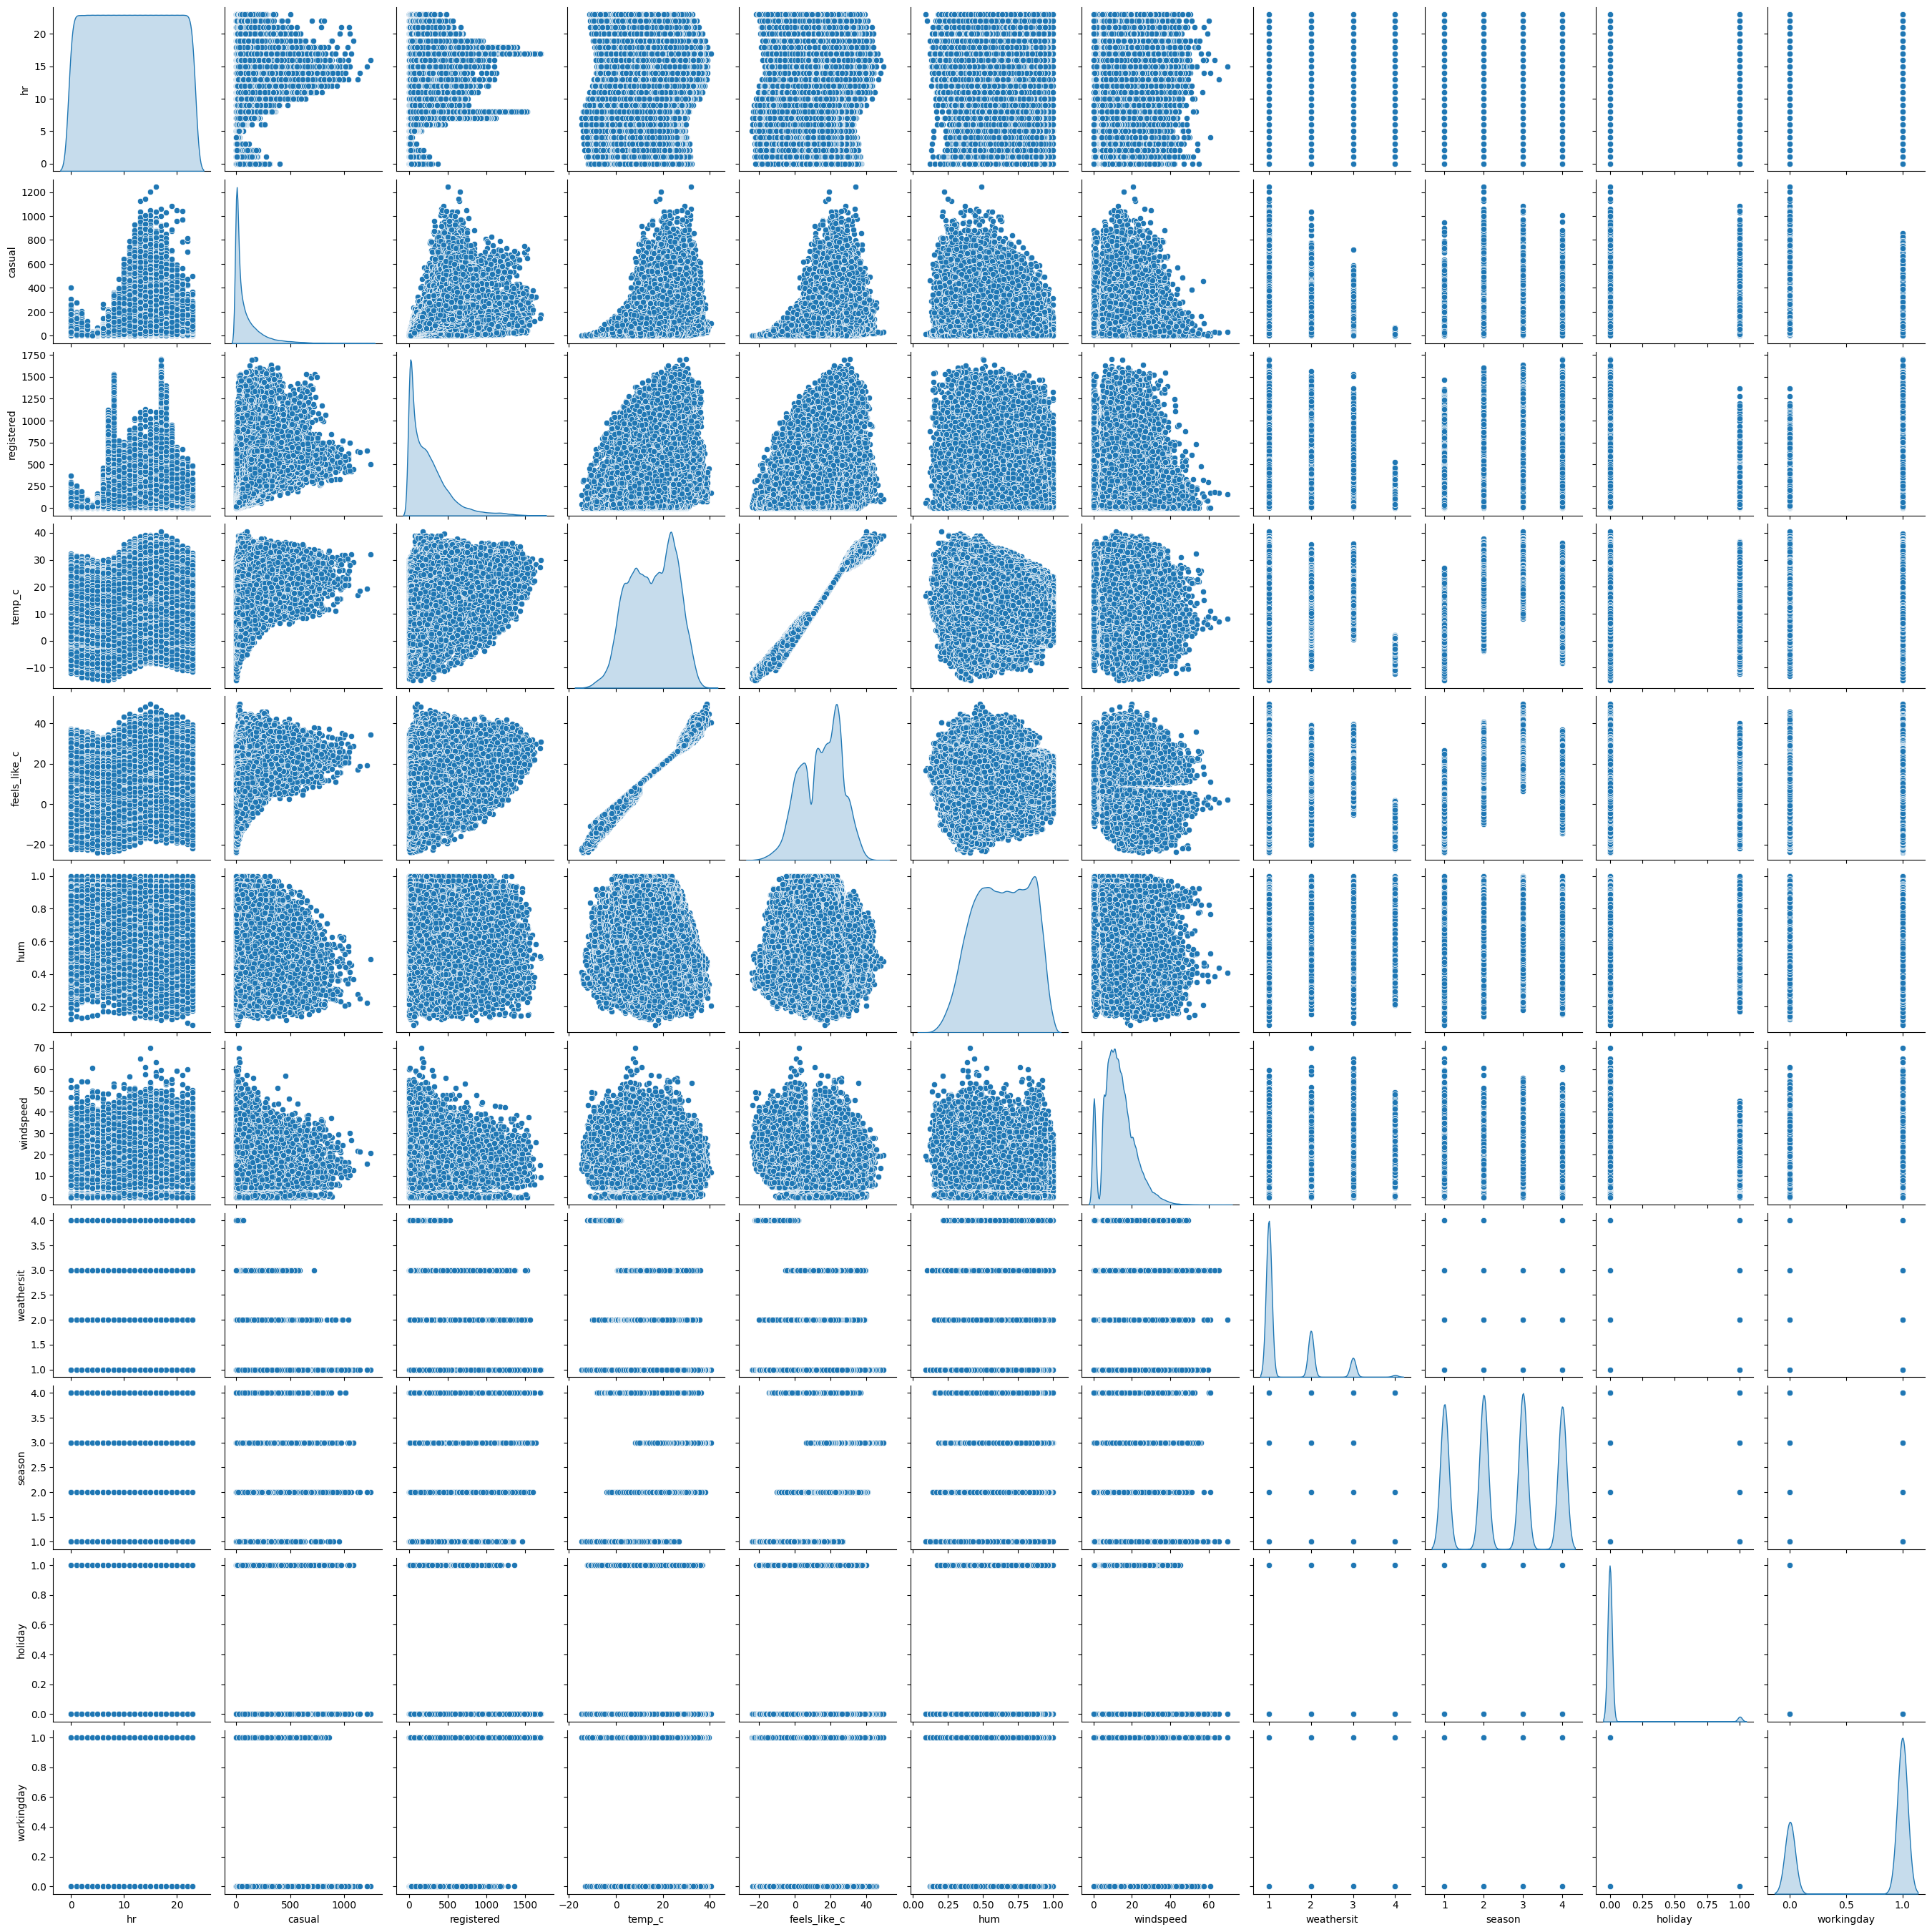

In [ ]:
import seaborn as sns
sns.pairplot(data=bikes, diag_kind='kde')

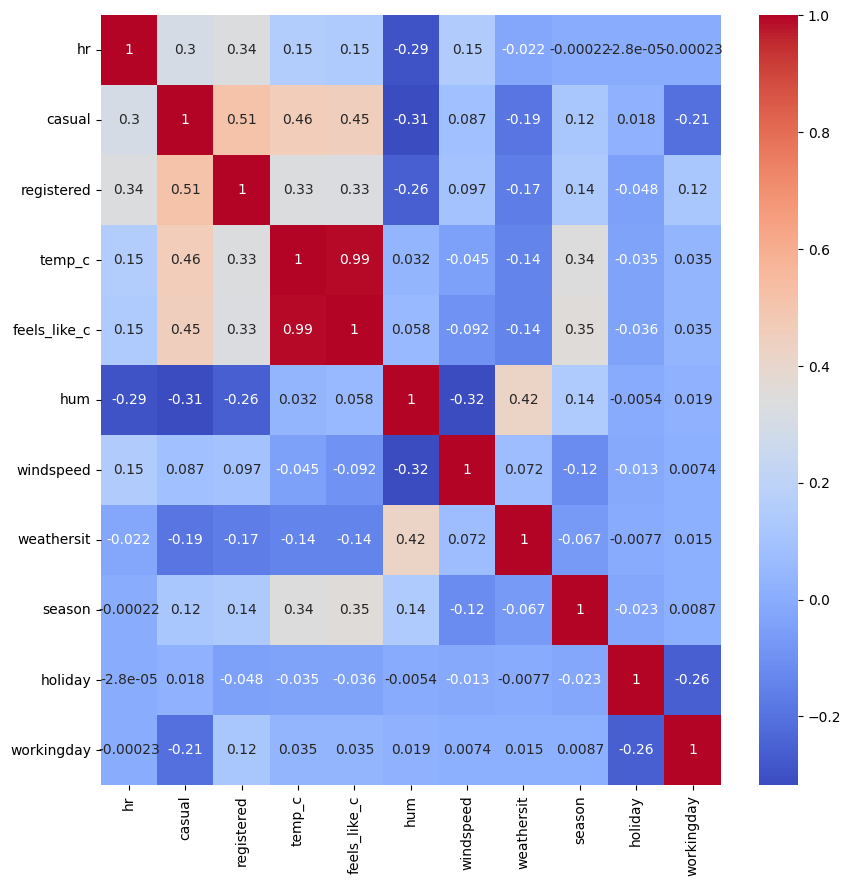

In [ ]:
import matplotlib.pyplot as plt


# Convert 'dteday' column to datetime objects
bikes['dteday'] = pd.to_datetime(bikes['dteday'])

# Extract numerical features for correlation calculation
numerical_features = bikes.select_dtypes(include=['number'])

plt.figure(figsize=(10, 10))
sns.heatmap(numerical_features.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
seasonal = bikes[[]]

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load and preprocess data
X = bikes.drop(columns=['casual', 'registered', 'dteday'])
y = bikes['casual'] + bikes['registered']  # Target variable

categorical_features = ['season', 'weathersit', 'holiday', 'workingday']
numeric_features = ['temp_c', 'feels_like_c', 'hum', 'windspeed', 'hr']

# Preprocessing: StandardScaler for numerical, OneHotEncoder for categorical
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

X = preprocessor.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Model with Hyperparameter Tuning
def build_model(hp):
    model = keras.Sequential()

    # Input layer with tunable units
    model.add(Dense(units=hp.Int('units_input', min_value=16, max_value=128, step=16),
                    activation='relu',
                    input_shape=(X_train.shape[1],)))

    # Hidden layers with tunable number of layers & units
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=16),
                        activation='relu'))

        # Add dropout with a tunable rate
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Compile model with tunable learning rate
    model.compile(optimizer=Adam(
                      hp.Choice('learning_rate', values=[0.001, 0.0001, 0.00001])),
                  loss='mse',
                  metrics=['mse', 'mae'])

    return model

# Hyperparameter tuning with Hyperband
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,  # Maximum number of epochs per trial
    factor=3,       # Reduction factor for Hyperband
    directory='tuning_dir',
    project_name='bike_sharing_hyperband'
)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform Hyperparameter Search
tuner.search(X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=2)

# Retrieve best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate model
test_loss, test_mse, test_mae = best_model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")

# Make predictions
predictions = best_model.predict(X_test)

# Calculate R² score on the test set
r2 = r2_score(y_test, predictions)
print(f"Test R²: {r2}")

# Plot Training vs Validation Loss
history = best_model.history.history
train_loss = history['loss']
val_loss = history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss with Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Trial 90 Complete [00h 06m 53s]
val_loss: 73724.90625

Best val_loss So Far: 24170.2734375
Total elapsed time: 01h 53m 15s
Best hyperparameters: {'units_input': 112, 'num_layers': 3, 'units_0': 48, 'dropout_0': 0.0, 'learning_rate': 0.001, 'units_1': 64, 'dropout_1': 0.0, 'units_2': 112, 'dropout_2': 0.30000000000000004, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0046'}
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 24509.0820 - mae: 99.5522 - mse: 24509.0820
Test MAE: 99.9820327758789
Test MSE: 24776.068359375
703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test R²: 0.7892476320266724


KeyError: 'loss'

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2531/2531 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 80455.1875 - mae: 189.5655 - mse: 80455.1875 - val_loss: 39948.1250 - val_mae: 133.4318 - val_mse: 39948.1250
Epoch 2/50
2531/2531 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 35579.6758 - mae: 119.9906 - mse: 35579.6758 - val_loss: 29144.8242 - val_mae: 111.9020 - val_mse: 29144.8242
Epoch 3/50
2531/2531 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 30364.5410 - mae: 110.9279 - mse: 30364.5410 - val_loss: 27390.2676 - val_mae: 106.2364 - val_mse: 27390.2676
Epoch 4/50
2531/2531 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 28821.6934 - mae: 107.9195 - mse: 28821.6934 - val_loss: 25700.6406 - val_mae: 104.2455 - val_mse: 25700.6406
Epoch 5/50
2531/2531 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 28160.6523 - mae: 106.2527 - mse: 28160.6523 - val_loss: 26942.2754 - val_mae: 107.3899 - val_mse: 26942.2754
Epoch 6/50
2531/2531 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 27934.4766 - mae: 106.1061 - mse: 27934.4766 - val_loss: 26365.0625 - val_mae: 104.65

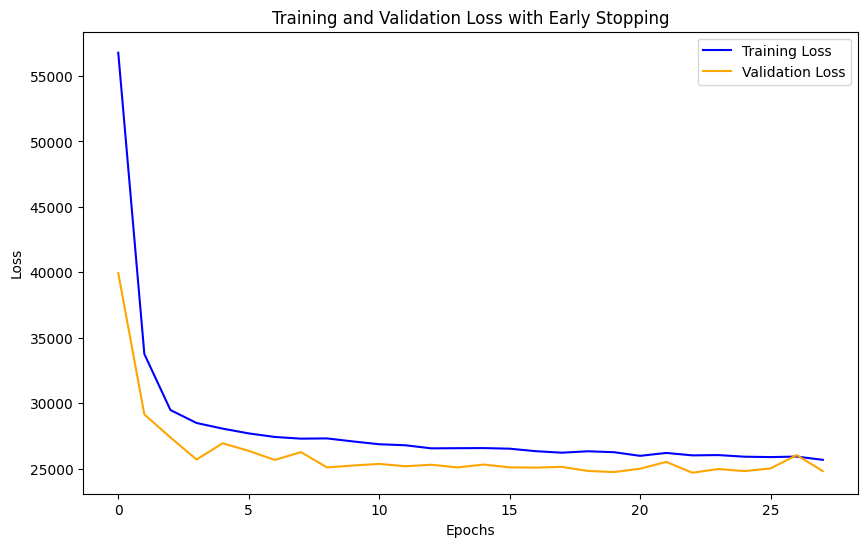

In [5]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = build_model(best_hps)

X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

history = best_model.fit(
    X_train_new, y_train_new,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

# Retrieve loss values for plotting
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss with Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [8]:

np.savetxt("bike_sharing_predictions.csv", predictions, delimiter=",", header="Predicted_Rentals", comments="")

print(predictions[:10])  # Shows first 10 predictions


[[508.25455 ]
 [984.1069  ]
 [545.5402  ]
 [514.7717  ]
 [ 82.5318  ]
 [560.8085  ]
 [679.52655 ]
 [807.269   ]
 [574.65106 ]
 [ 46.461006]]
